# Análise Exploratória da Educação no Estado do Rio de Janeiro

Esse trabalho consiste em uma análise exploratória dos dados do Índice de Desenvolvimento da Educação Básica (Ideb) e outros índices nos municípios do estado do Rio de Janeiro.

Utilizamos bases de dados retiradas do site [Base dos Dados](https://basedosdados.org/dataset/br-inep-ideb), com os dados do Ideb, e um arquivo GeoJSON retirado de [geodata-br](https://github.com/tbrugz/geodata-br), com os dados geográficos necessários dos municípios do Rio de Janeiro, para realizar as visualizações usando geopandas e outras ferramentas.

## Sumário

* [Importação das bibliotecas](#pct)
* [Preparação das bases](#bases)
    * [Dados geográficos](#1base)
    * [Dados IDEB](#2base)
* [Criação do banco de dados](#banco)
    * [Conexões entre as tabelas](#conn)
    * [Adição de metadados](#meta)
    * [Preparação para a análise](#pre_ana)
* [Análise Exploratória](#analise)

## Bibliotecas necessárias <a class="anchor" id="pct"></a>

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sqlalchemy import create_engine
from geoalchemy2 import Geometry
import sqlite3
import matplotlib
from shapely import wkt #converter de string para geometry
import mapclassify #para plotar os gráficos
import matplotlib.pyplot as plt

## Preparação das as bases <a class="anchor" id="bases"></a>

### Dados geográficos <a class="anchor" id="1base"></a>

A primeira base consiste nos dados geográficos dos municípios do Rio de Janeiro que vamos utilizar para plotar os mapas.

Usamos o [DownGit](https://downgit.github.io/#/home) para fazer o download do `.json` do [ Repositório Telmo](https://github.com/tbrugz/geodata-br/blob/master/geojson/geojs-33-mun.json)

In [2]:
zipfile = "geojs-33-mun.json.zip"
rio_municipios = gpd.read_file(zipfile)
rio_municipios = rio_municipios.drop(columns = 'description') #A coluna description é igual à coluna name, então vamos retirá-la

print(type(rio_municipios))

rio_municipios.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


,id,name,geometry
0,3300100,Angra dos Reis,"POLYGON ((-44.19557 -23.09831, -44.19445 -23.1..."
1,3300159,Aperibé,"POLYGON ((-42.11517 -21.60398, -42.11585 -21.6..."
2,3300209,Araruama,"POLYGON ((-42.18220 -22.55217, -42.13226 -22.6..."
3,3300225,Areal,"POLYGON ((-43.05873 -22.18937, -43.04773 -22.2..."
4,3300233,Armação dos Búzios,"POLYGON ((-41.93436 -22.76580, -41.91900 -22.7..."


### Dados IDEB e SAEB <a class="anchor" id="2base"></a>

Já a segunda base reúne todos os dados sobre o Índice de Desenvolvimento da Educação Básica (Ideb) e do Sistema de Avaliação da Educação Básica (Saeb). Vamos filtrá-la e utilizar apenas os dados referentes ao estado do Rio.

In [3]:
csvfile = "municipio.csv"
municipio = gpd.read_file(csvfile)
municipio.head()

,ano,sigla_uf,id_municipio,rede,ensino,anos_escolares,taxa_aprovacao,indicador_rendimento,nota_saeb_matematica,nota_saeb_lingua_portuguesa,nota_saeb_media_padronizada,ideb,projecao,geometry
0,2005,AC,1200013,estadual,fundamental,finais (6-9),90,0.89959502,223.3,209.69,3.88221,3.5,,None
1,2005,AC,1200013,estadual,fundamental,iniciais (1-5),80.4,0.76059997,167.8,154.39,3.972965,3,,None
2,2005,AC,1200013,municipal,fundamental,finais (6-9),,,,,,,,None
3,2005,AC,1200013,municipal,fundamental,iniciais (1-5),66.3,0.68155998,169.8,163,4.1680932,2.8,,None
4,2005,AC,1200013,publica,fundamental,finais (6-9),89,0.89366102,223.3,209.69,3.8821671,3.5,,None


Filtrando a base para selecionar apenas os dados desejados:

In [4]:
dados_rio = municipio[municipio['sigla_uf'] == "RJ"]
dados_rio = dados_rio.drop(columns = ['projecao','geometry']) #deleta a coluna projecao, pois há poucos dados sobre ela, e  a coluna
 #geometry pois essa base não possui esse tipo de dado
dados_rio.tail()

,ano,sigla_uf,id_municipio,rede,ensino,anos_escolares,taxa_aprovacao,indicador_rendimento,nota_saeb_matematica,nota_saeb_lingua_portuguesa,nota_saeb_media_padronizada,ideb
280698,2021,RJ,3306305,municipal,fundamental,iniciais (1-5),,,,,,
280699,2021,RJ,3306305,municipal,medio,todos (1-4),,,,,,
280700,2021,RJ,3306305,publica,fundamental,finais (6-9),,,,,,
280701,2021,RJ,3306305,publica,fundamental,iniciais (1-5),,,,,,
280702,2021,RJ,3306305,publica,medio,todos (1-4),,,,,,


Aproveitamos para deletar as linhas com dados faltantes e assim facilitar as nossas análises.

In [5]:
dados_rio['taxa_aprovacao'].replace('', np.nan, inplace=True)
dados_rio.dropna(subset=['taxa_aprovacao'], inplace=True)
dados_rio.index.names = ["id_dado"]
dados_rio

,ano,sigla_uf,id_municipio,rede,ensino,anos_escolares,taxa_aprovacao,indicador_rendimento,nota_saeb_matematica,nota_saeb_lingua_portuguesa,nota_saeb_media_padronizada,ideb
id_dado,,,,,,,,,,,,
18479,2005,RJ,3300100,estadual,fundamental,finais (6-9),69.6,0.69632202,241.39,230.69,4.5339708,3.2
18480,2005,RJ,3300100,estadual,fundamental,iniciais (1-5),81.5,0.81477797,179.8,173,4.5396662,3.7
18481,2005,RJ,3300100,municipal,fundamental,finais (6-9),69.2,0.70024502,247.19,236,4.7203331,3.3
18482,2005,RJ,3300100,municipal,fundamental,iniciais (1-5),73.9,0.73932397,189.39,182.19,4.8886571,3.6
18483,2005,RJ,3300100,publica,fundamental,finais (6-9),69.4,0.69687301,242.89,232,4.5811672,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...
240234,2019,RJ,3306305,municipal,fundamental,iniciais (1-5),91.8,0.91792399,242.47,230.5,6.782443,6.2
240235,2019,RJ,3306305,municipal,medio,todos (1-4),86.1,0.86114401,315.45,307.6,5.7250719,4.9
240236,2019,RJ,3306305,publica,fundamental,finais (6-9),88.8,0.888152,272.42,264.8,5.6205001,5


## Criação do banco de dados <a class="anchor" id="banco"></a>

Primeiro criamos a conexão e a tabela vazia 

In [6]:
conn = sqlite3.connect('ideb-database.db')
cur = conn.cursor()

In [7]:
cur.execute('''CREATE TABLE IF NOT EXISTS municipios_rio
             ('id_municipio' INT PRIMARY KEY NOT NULL,
             'name' text, 
             'geometry' text)''')
conn.commit()

Como não é possível passar o dataframe em Geopandas para o banco de dados, convertemos a tabela para Pandas e a coluna geometry para string

In [8]:
rio_municipios_pd = pd.DataFrame(rio_municipios)
rio_municipios_pd['geometry'] = rio_municipios_pd['geometry'].astype(str)

In [9]:
rio_municipios_pd.to_sql('municipios_rio', con=conn, if_exists='replace')
conn.commit()

Para checar que os dados foram adicionados na tabela, inicialmente vazia, fizemos uma query teste

In [10]:
cur.execute("SELECT name FROM municipios_rio")
print(cur.fetchmany(10))

[('Angra dos Reis',), ('Aperibé',), ('Araruama',), ('Areal',), ('Armação dos Búzios',), ('Arraial do Cabo',), ('Barra do Piraí',), ('Barra Mansa',), ('Belford Roxo',), ('Bom Jardim',)]


O mesmo procedimento é realizado para o dataframe `dados_rio`, criando a tabela vazia, convertendo para Pandas e depois dazendo uma query teste

In [11]:
cur.execute('''CREATE TABLE IF NOT EXISTS dados_ideb_rio
             ('id_dado' INT PRIMARY KEY NOT NULL,
             'ano' INT NOT NULL,
             'sigla_uf' text,
             'id_municipio' INT NOT NULL,
             'rede' TEXT ,
             'ensino' TEXT,
             'anos_escolares' TEXT,
             'taxa_aprovacao' REAL,
             'indicador_rendimento' REAL,
             'nota_saeb_matematica' REAL,
             'nota_saeb_lingua_portuguesa' REAL,
             'nota_saeb_media_padronizada' REAL,
             'ideb' REAL)''')
conn.commit()

In [12]:
dados_rio.to_sql('dados_ideb_rio', con=conn, if_exists='replace')
conn.commit()

In [13]:
cur.execute("SELECT id_dado FROM dados_ideb_rio")
print(cur.fetchmany(10))

[(18479,), (18480,), (18481,), (18482,), (18483,), (18484,), (18485,), (18488,), (18489,), (18490,)]


### Conexões entre as tabelas <a class="anchor" id="conn"></a>

Cria uma tabela que relaciona as duas outras

In [14]:
cur.execute('''CREATE TABLE IF NOT EXISTS rel_municipios
             ('id_rel' INTEGER PRIMARY KEY AUTOINCREMENT,
              'id_dado' INT,
              'id_municipio' INT,
               FOREIGN KEY (id_dado)
                    REFERENCES dados_ideb_rio (id_dado)
               FOREIGN KEY (id_municipio)
                    REFERENCES municipios_rio (id_municipio)
             )''')
conn.commit()

Checa se todas as colunas da tabela foram adicionadas corretamente

In [15]:
cur.execute('''PRAGMA table_info(rel_municipios)''')
print(cur.fetchall())

[(0, 'id_rel', 'INTEGER', 0, None, 1), (1, 'id_dado', 'INT', 0, None, 0), (2, 'id_municipio', 'INT', 0, None, 0)]


In [16]:
cur.execute('''INSERT INTO rel_municipios (id_dado, id_municipio)
                SELECT id_dado,id_municipio
                FROM dados_ideb_rio;
            ''')
conn.commit()

In [17]:
cur.execute("SELECT * FROM rel_municipios")
print(cur.fetchmany(10))

[(1, 18479, 3300100), (2, 18480, 3300100), (3, 18481, 3300100), (4, 18482, 3300100), (5, 18483, 3300100), (6, 18484, 3300100), (7, 18485, 3300159), (8, 18488, 3300159), (9, 18489, 3300159), (10, 18490, 3300159)]


Por fim, checamos se todas as tabelas foram criadas no banco de dados

In [18]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('sqlite_sequence',), ('rel_municipios',), ('pessoas_meta',), ('dados_ideb_rio_meta',), ('municipios_rio',), ('dados_ideb_rio',)]


### Adição de metadados <a class="anchor" id="meta"></a>

Primeiro, como os limites dos municípios podem ser alterados ao longo do tempo, vamos adicionar a última data de modificação na tabela `municipios_rio`

#### last_update

In [19]:
cur.execute('''ALTER TABLE municipios_rio
                ADD geom_last_update TEXT''')
conn.commit()

In [20]:
cur.execute('''UPDATE municipios_rio 
                SET geom_last_update = '2021-11-12' ''')
conn.commit()

Checando se os dados foram adicionados na tabela

In [21]:
cur.execute("SELECT geom_last_update FROM municipios_rio")
print(cur.fetchmany(10))

[('2021-11-12',), ('2021-11-12',), ('2021-11-12',), ('2021-11-12',), ('2021-11-12',), ('2021-11-12',), ('2021-11-12',), ('2021-11-12',), ('2021-11-12',), ('2021-11-12',)]


#### media_nota

In [22]:
cur.execute('''ALTER TABLE dados_ideb_rio
                ADD media_nota REAL''')
conn.commit()

In [23]:
cur.execute('''UPDATE dados_ideb_rio 
                SET media_nota = ((nota_saeb_lingua_portuguesa + nota_saeb_matematica) / 2)''')

conn.commit()

Checando se as notas médias foram adicionadas na tabela

In [24]:
cur.execute('''SELECT media_nota
                FROM dados_ideb_rio''')

print(cur.fetchmany(10))

[(236.04,), (176.4,), (241.595,), (185.79,), (237.445,), (183.69,), (215.345,), (202.29,), (215.345,), (202.29,)]


#### dados_ideb_rio_meta e pessoas_meta

In [25]:
cur.execute('''CREATE TABLE IF NOT EXISTS pessoas_meta
             ('id_pessoa' INT PRIMARY KEY,
               'nome' TEXT,
               'sobrenome' TEXT,
               'email' TEXT,
               'code_url' TEXT,
               'website' TEXT)''')
conn.commit()

In [26]:
cur.execute('''CREATE TABLE IF NOT EXISTS dados_ideb_rio_meta
             ('id_meta' INT PRIMARY KEY,
             'conjunto' TEXT,
             'tabela' TEXT,
             'cobertura_espacial' TEXT,
             'inicio_cobertura_temporal' INT,
             'final_cobertura_temporal' INT,
             'freq_atualizacao' INT,
             'versao' REAL,
             'publicado_por' INT,
             'limpo_por' INT,
             FOREIGN KEY (publicado_por)
                REFERENCES pessoas_meta (id_pessoa)
             FOREIGN KEY (limpo_por)
                REFERENCES pessoas_meta (id_pessoa))''')
conn.commit()

In [27]:
cur.execute('''UPDATE dados_ideb_rio_meta 
                SET id_meta = 1,
                        conjunto = 'br_inep_ideb',
                        tabela = 'brasil',
                        cobertura_espacial = 'Brasil',
                        inicio_cobertura_temporal = '2005',
                        final_cobertura_temporal = '2019',
                        freq_atualizacao = '2',
                        versao = '1.0',
                        publicado_por = '1',
                        limpo_por = '1' ''')
conn.commit()

In [28]:
cur.execute('''SELECT * FROM dados_ideb_rio_meta''')
print(cur.fetchmany(10))

[(1, 'br_inep_ideb', 'brasil', 'Brasil', 2005, 2019, 2, 1.0, 1, 1)]


In [29]:
cur.execute('''UPDATE pessoas_meta 
                SET id_pessoa = 1,
                        nome = 'Ricardo',
                        sobrenome = 'Dahis',
                        email = 'rdahis@basedosdados.org',
                        code_url = 'https://github.com/basedosdados/mais/tree/master/bases/br_inep_ideb/code',
                        website = 'www.ricardodahis.com'
                        ''')
conn.commit()

In [30]:
cur.execute('''SELECT * FROM pessoas_meta''')
print(cur.fetchmany(10))

[(1, 'Ricardo', 'Dahis', 'rdahis@basedosdados.org', 'https://github.com/basedosdados/mais/tree/master/bases/br_inep_ideb/code', 'www.ricardodahis.com')]


### Preparação para a análise <a class="anchor" id="pre_ana"></a>

In [31]:
dados = '''SELECT * FROM dados_ideb_rio d LEFT JOIN municipios_rio m ON d.id_municipio=m.id
'''

cur.execute(dados)
df = pd.read_sql_query(dados, conn)
df.head() 

,id_dado,ano,sigla_uf,id_municipio,rede,ensino,anos_escolares,taxa_aprovacao,indicador_rendimento,nota_saeb_matematica,nota_saeb_lingua_portuguesa,nota_saeb_media_padronizada,ideb,media_nota,index,id,name,geometry,geom_last_update
0,18479,2005,RJ,3300100,estadual,fundamental,finais (6-9),69.6,0.69632202,241.39,230.69,4.5339708,3.2,236.040,0,3300100,Angra dos Reis,"POLYGON ((-44.1955721491 -23.0983083542, -44.1...",2021-11-12
1,18480,2005,RJ,3300100,estadual,fundamental,iniciais (1-5),81.5,0.81477797,179.8,173,4.5396662,3.7,176.400,0,3300100,Angra dos Reis,"POLYGON ((-44.1955721491 -23.0983083542, -44.1...",2021-11-12
2,18481,2005,RJ,3300100,municipal,fundamental,finais (6-9),69.2,0.70024502,247.19,236,4.7203331,3.3,241.595,0,3300100,Angra dos Reis,"POLYGON ((-44.1955721491 -23.0983083542, -44.1...",2021-11-12
3,18482,2005,RJ,3300100,municipal,fundamental,iniciais (1-5),73.9,0.73932397,189.39,182.19,4.8886571,3.6,185.790,0,3300100,Angra dos Reis,"POLYGON ((-44.1955721491 -23.0983083542, -44.1...",2021-11-12
4,18483,2005,RJ,3300100,publica,fundamental,finais (6-9),69.4,0.69687301,242.89,232,4.5811672,3.2,237.445,0,3300100,Angra dos Reis,"POLYGON ((-44.1955721491 -23.0983083542, -44.1...",2021-11-12


Retiramos as colunas 'id' e 'index', pois o *id* está duplicada e o *index* não será utilizado.

In [32]:
df = df.drop(columns = ['id','index']) 

In [33]:
df.dtypes

id_dado                          int64
ano                             object
sigla_uf                        object
id_municipio                    object
rede                            object
ensino                          object
anos_escolares                  object
taxa_aprovacao                  object
indicador_rendimento            object
nota_saeb_matematica            object
nota_saeb_lingua_portuguesa     object
nota_saeb_media_padronizada     object
ideb                            object
media_nota                     float64
name                            object
geometry                        object
geom_last_update                object
dtype: object

Agora, para conseguirmos plotar mapas, transformamos nossa base em uma *GeoDataFrame*:

In [34]:
df = gpd.GeoDataFrame(df)

In [35]:
df.dtypes # verifica o tipo de dado de cada coluna

id_dado                          int64
ano                             object
sigla_uf                        object
id_municipio                    object
rede                            object
ensino                          object
anos_escolares                  object
taxa_aprovacao                  object
indicador_rendimento            object
nota_saeb_matematica            object
nota_saeb_lingua_portuguesa     object
nota_saeb_media_padronizada     object
ideb                            object
media_nota                     float64
name                            object
geometry                        object
geom_last_update                object
dtype: object

É possível observar que os dados da coluna geometria não são do tipo *geometry*, por isso vamos transformá-los. Além disso, também é necessário transformar os dados númericos em *float*, para que seja possível realizar as análises.

In [36]:
df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry']) 

Utilizamos pandas para transformar os dados numéricos:

In [37]:
df['taxa_aprovacao'] = pd.to_numeric(df['taxa_aprovacao'],errors='coerce')
df['indicador_rendimento'] = pd.to_numeric(df['indicador_rendimento'],errors='coerce')
df['nota_saeb_matematica'] = pd.to_numeric(df['nota_saeb_matematica'],errors='coerce')
df['nota_saeb_lingua_portuguesa'] = pd.to_numeric(df['nota_saeb_lingua_portuguesa'],errors='coerce')
df['nota_saeb_media_padronizada'] = pd.to_numeric(df['nota_saeb_media_padronizada'],errors='coerce')
df['ideb'] = pd.to_numeric(df['ideb'],errors='coerce')

In [38]:
df.dtypes

id_dado                           int64
ano                              object
sigla_uf                         object
id_municipio                     object
rede                             object
ensino                           object
anos_escolares                   object
taxa_aprovacao                  float64
indicador_rendimento            float64
nota_saeb_matematica            float64
nota_saeb_lingua_portuguesa     float64
nota_saeb_media_padronizada     float64
ideb                            float64
media_nota                      float64
name                             object
geometry                       geometry
geom_last_update                 object
dtype: object

Finalmente, podemos começar a plotar os mapas e realizar as análises.

## Análise Exploratória <a class="anchor" id="analise"></a>

Estamos utilizando uma base rica em dados que nos permite uma grande variedade de tipos de análises. 

Legenda dos indicadores:
+ Indicador de rendimento: Soma da quantidade de alunos aprovados, reprovados e que abandonaram a escola ao final de um ano letivo. O indicador é utilizado no cálculo do Ideb.

+ Saeb: O Sistema de Avaliação da Educação Básica (Saeb) é um conjunto de avaliações externas em larga escala que permite ao Inep realizar um diagnóstico da educação básica brasileira e de fatores que podem interferir no desempenho do estudante. Por meio de testes e questionários, aplicados a cada dois anos na rede pública e em uma amostra da rede privada, o Saeb reflete os níveis de aprendizagem demonstrados pelos estudantes avaliados.

+ Ideb: É o Índice de Desenvolvimento da Educação Básica criado pelo governo federal para medir a qualidade do ensino nas escolas públicas. O resultado é publicado de 2 em 2 anos, sendo o último, o de 2019.

### Estado do Rio de Janeiro

Text(0.5, 1.0, 'Limites Municipais Rio de Janeiro')

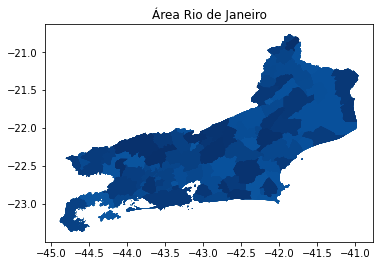

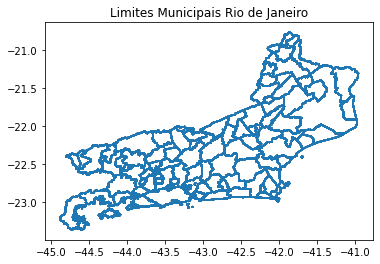

In [39]:
a1 = df.plot( legend='Rio de Janeiro', cmap='Blues')
a2 = df.boundary.plot();
a1.set_title('Área Rio de Janeiro')
a2.set_title("Limites Municipais Rio de Janeiro")

### Municípios que se destacam na educação básica, a partir do Ideb, das taxas de aprovação e dos índices de rendimento.

 Faremos um agregado com a média dos últimos anos.

In [40]:
rank_ideb = df[['name', 'ideb', 'taxa_aprovacao', 'indicador_rendimento'
]].groupby(['name']).mean(['ideb', 'taxa_aprovacao', 'indicador_rendimento']).sort_values('ideb',ascending=False)
# ordenando acordo com o ideb de forma descrescente

rank_ideb

,ideb,taxa_aprovacao,indicador_rendimento
name,,,
Santo Antônio de Pádua,5.189362,91.170833,0.912127
Trajano de Moraes,5.092308,87.987805,0.882319
Sumidouro,5.022222,85.637838,0.858170
Itaocara,4.952083,85.008163,0.852302
Itaperuna,4.942000,89.847059,0.899680
...,...,...,...
São Gonçalo,3.604000,75.914000,0.761026
Duque de Caxias,3.603922,76.709804,0.772001
São João de Meriti,3.589796,77.993878,0.787206


Text(0.5, 1.0, 'Ideb por munícipio')

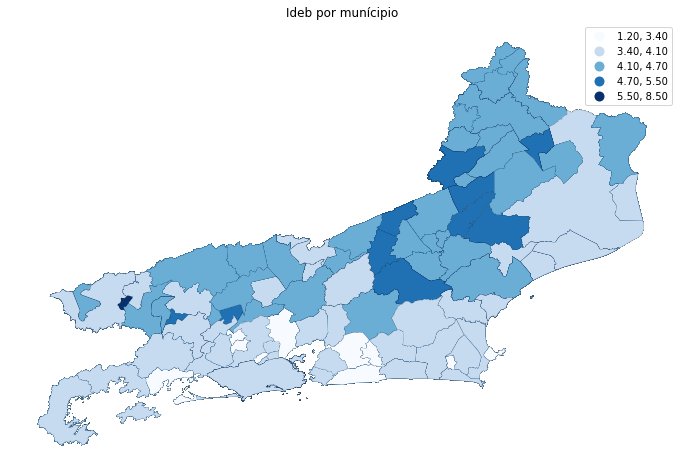

In [41]:
ideb_mun = df.plot(
    column="ideb",
    figsize=(12, 12), 
    edgecolor = 'black', 
    linewidth = 0.05,
    legend=True,
    cmap='Blues',
    scheme="natural_breaks")

ideb_mun.set_axis_off()
ideb_mun.set_title('Ideb por munícipio')

Text(0.5, 1.0, 'Taxa de aprovação por munícipio')

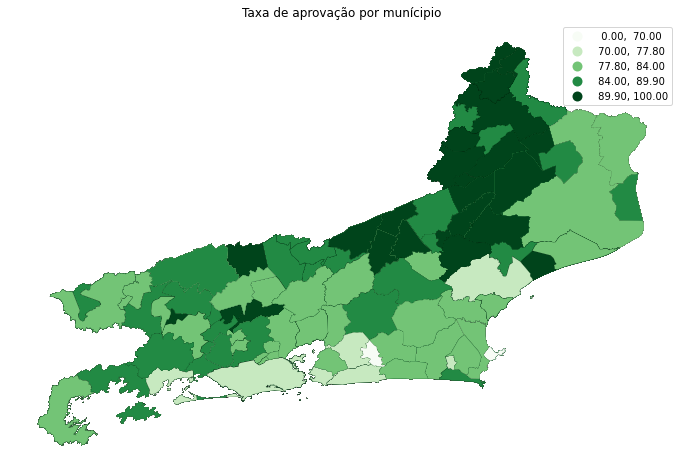

In [42]:
aprov_mun = df.plot(
    column="taxa_aprovacao",
    figsize=(12, 12), 
    edgecolor = 'black', 
    linewidth = 0.05,
    legend=True,
    cmap='Greens',
    scheme="natural_breaks")

aprov_mun.set_axis_off()
aprov_mun.set_title('Taxa de aprovação por munícipio')

Text(0.5, 1.0, 'Indicador de rendimento por munícipio')

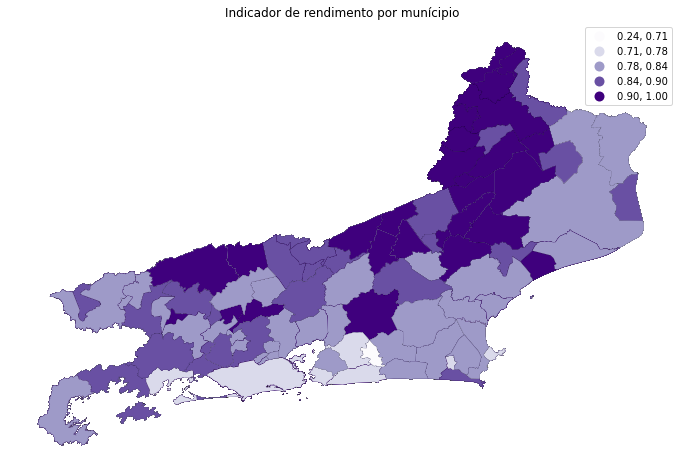

In [43]:
rendimento_mun = df.plot(
    column="indicador_rendimento",
    figsize=(12, 12), 
    edgecolor = 'black', 
    linewidth = 0.05,
    legend=True,
    cmap='Purples',
    scheme="natural_breaks")

rendimento_mun.set_axis_off()
rendimento_mun.set_title('Indicador de rendimento por munícipio')

Através desses três mapas é possível observar que os municípios que apresentam os maiores indicadores são, em geral, os mesmos e que eles sem concentram principalmente no interior do estado. Além disso, vê-se que a região metropolitana é a que possui menores notas.

### Comparação das notas Saeb de matemática e português nos municípios do Rio de Janeiro

In [44]:
rank_saeb = df[['name','nota_saeb_matematica', 'nota_saeb_lingua_portuguesa', 'nota_saeb_media_padronizada'
]].groupby(['name']).mean(['nota_saeb_matematica', 'nota_saeb_lingua_portuguesa', 'nota_saeb_media_padronizada']).sort_values('nota_saeb_media_padronizada',ascending=False)
# ordenando acordo com o ideb de forma descrescente

rank_saeb

,nota_saeb_matematica,nota_saeb_lingua_portuguesa,nota_saeb_media_padronizada
name,,,
Miguel Pereira,257.613571,246.435714,5.849629
Sumidouro,257.895625,245.663750,5.829782
Itaocara,256.411628,241.619302,5.788991
Nova Friburgo,253.856667,244.583111,5.771485
Bom Jardim,254.389545,241.429773,5.770095
...,...,...,...
Nova Iguaçu,215.354773,209.216591,4.547899
São João de Meriti,215.817045,209.048182,4.545055
Queimados,215.294651,210.350465,4.511081


Text(0.5, 1.0, 'Nota Saeb Matemática')

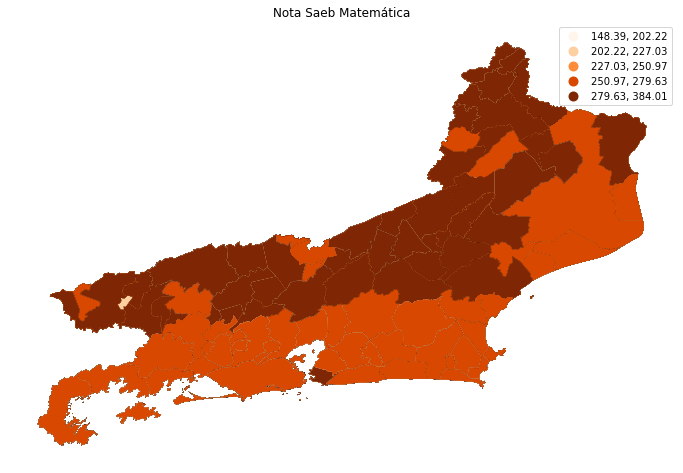

In [45]:
saeb_mat = df.plot(
    column="nota_saeb_matematica",
    figsize=(12, 12), 
    edgecolor = 'black', 
    linewidth = 0.05,
    legend=True,
    cmap='Oranges',
    scheme="natural_breaks")

saeb_mat.set_axis_off()
saeb_mat.set_title('Nota Saeb Matemática')

Text(0.5, 1.0, 'Nota Saeb Língua Portuguesa')

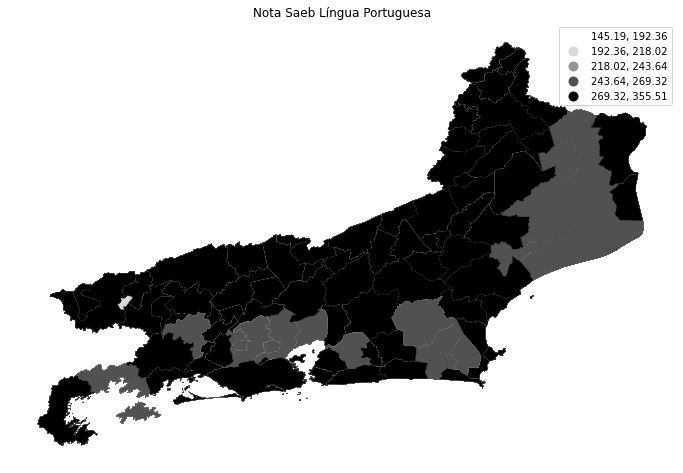

In [46]:
saeb_port = df.plot(
    column="nota_saeb_lingua_portuguesa",
    figsize=(12, 12), 
    edgecolor = 'black', 
    linewidth = 0.05,
    legend=True,
    cmap='Greys',
    scheme="natural_breaks")

saeb_port.set_axis_off()
saeb_port.set_title('Nota Saeb Língua Portuguesa')

In [47]:
print("Média nota Saeb Matemática =",rank_saeb['nota_saeb_matematica'].mean(),"\nMédia nota Saeb Língua Portuguesa=", rank_saeb['nota_saeb_lingua_portuguesa'].mean())


Média nota Saeb Matemática = 235.84127883386998 
Média nota Saeb Língua Portuguesa= 226.98207542535854




No caso das notas de matemática, o resultado é similar ao do Ideb, com concentração dos melhores resultados no interior do estado. Já as de língua portuguesa, a concentração geográfica é menor.

### Crecimento das notas entre anos de 2005 e 2019

In [48]:
rank_anos= df

municipios_rj = df[['name','geometry']]
municipios_rj = municipios_rj.drop_duplicates(subset=['name'])

In [49]:
rank_2005 = rank_anos[rank_anos["ano"]=='2005']
rank_2007 = rank_anos[rank_anos["ano"]=='2007']
rank_2009 = rank_anos[rank_anos["ano"]=='2009']
rank_2011 = rank_anos[rank_anos["ano"]=='2011']
rank_2013 = rank_anos[rank_anos["ano"]=='2013']
rank_2015 = rank_anos[rank_anos["ano"]=='2015']
rank_2017 = rank_anos[rank_anos["ano"]=='2017']
rank_2019 = rank_anos[rank_anos["ano"]=='2019']

In [50]:
rank_2005 = rank_2005[['name','ano','ideb', 'taxa_aprovacao', 'indicador_rendimento','nota_saeb_matematica','nota_saeb_lingua_portuguesa']].groupby(['name']).mean(['ideb', 'taxa_aprovacao', 'indicador_rendimento','nota_saeb_matematica','nota_saeb_lingua_portuguesa']).sort_values('ideb',ascending=False)
rank_2007 = rank_2007[['name','ano','ideb', 'taxa_aprovacao', 'indicador_rendimento','nota_saeb_matematica','nota_saeb_lingua_portuguesa']].groupby(['name']).mean(['ideb', 'taxa_aprovacao', 'indicador_rendimento','nota_saeb_matematica','nota_saeb_lingua_portuguesa']).sort_values('ideb',ascending=False)
rank_2009 = rank_2009[['name','ano','ideb', 'taxa_aprovacao', 'indicador_rendimento','nota_saeb_matematica','nota_saeb_lingua_portuguesa']].groupby(['name']).mean(['ideb', 'taxa_aprovacao', 'indicador_rendimento','nota_saeb_matematica','nota_saeb_lingua_portuguesa']).sort_values('ideb',ascending=False)
rank_2011 = rank_2011[['name','ano','ideb', 'taxa_aprovacao', 'indicador_rendimento','nota_saeb_matematica','nota_saeb_lingua_portuguesa']].groupby(['name']).mean(['ideb', 'taxa_aprovacao', 'indicador_rendimento','nota_saeb_matematica','nota_saeb_lingua_portuguesa']).sort_values('ideb',ascending=False)
rank_2013 = rank_2013[['name','ano','ideb', 'taxa_aprovacao', 'indicador_rendimento','nota_saeb_matematica','nota_saeb_lingua_portuguesa']].groupby(['name']).mean(['ideb', 'taxa_aprovacao', 'indicador_rendimento','nota_saeb_matematica','nota_saeb_lingua_portuguesa']).sort_values('ideb',ascending=False)
rank_2015 = rank_2015[['name','ano','ideb', 'taxa_aprovacao', 'indicador_rendimento','nota_saeb_matematica','nota_saeb_lingua_portuguesa']].groupby(['name']).mean(['ideb', 'taxa_aprovacao', 'indicador_rendimento','nota_saeb_matematica','nota_saeb_lingua_portuguesa']).sort_values('ideb',ascending=False)
rank_2017 = rank_2017[['name','ano','ideb', 'taxa_aprovacao', 'indicador_rendimento','nota_saeb_matematica','nota_saeb_lingua_portuguesa']].groupby(['name']).mean(['ideb', 'taxa_aprovacao', 'indicador_rendimento','nota_saeb_matematica','nota_saeb_lingua_portuguesa']).sort_values('ideb',ascending=False)
rank_2019 = rank_2019[['name','ano','ideb', 'taxa_aprovacao', 'indicador_rendimento','nota_saeb_matematica','nota_saeb_lingua_portuguesa']].groupby(['name']).mean(['ideb', 'taxa_aprovacao', 'indicador_rendimento','nota_saeb_matematica','nota_saeb_lingua_portuguesa']).sort_values('ideb',ascending=False)

In [51]:
rank2_2005= rank_2005.merge(municipios_rj, left_on="name", right_on="name")
rank2_2005 = gpd.GeoDataFrame(rank2_2005)

rank2_2007= rank_2007.merge(municipios_rj, left_on="name", right_on="name")
rank2_2007 = gpd.GeoDataFrame(rank2_2007)

rank2_2009= rank_2009.merge(municipios_rj, left_on="name", right_on="name")
rank2_2009 = gpd.GeoDataFrame(rank2_2009)

rank2_2011= rank_2011.merge(municipios_rj, left_on="name", right_on="name")
rank2_2011 = gpd.GeoDataFrame(rank2_2011)

rank2_2013 = rank_2013.merge(municipios_rj, left_on="name", right_on="name")
rank2_2013 = gpd.GeoDataFrame(rank2_2013)

rank2_2015 = rank_2015.merge(municipios_rj, left_on="name", right_on="name")
rank2_2015 = gpd.GeoDataFrame(rank2_2015)

rank2_2017 = rank_2017.merge(municipios_rj, left_on="name", right_on="name")
rank2_2017 = gpd.GeoDataFrame(rank2_2017)

rank2_2019= rank_2019.merge(municipios_rj, left_on="name", right_on="name")
rank2_2019 = gpd.GeoDataFrame(rank2_2019)

Text(0.5, 1.0, 'Ideb 2019')

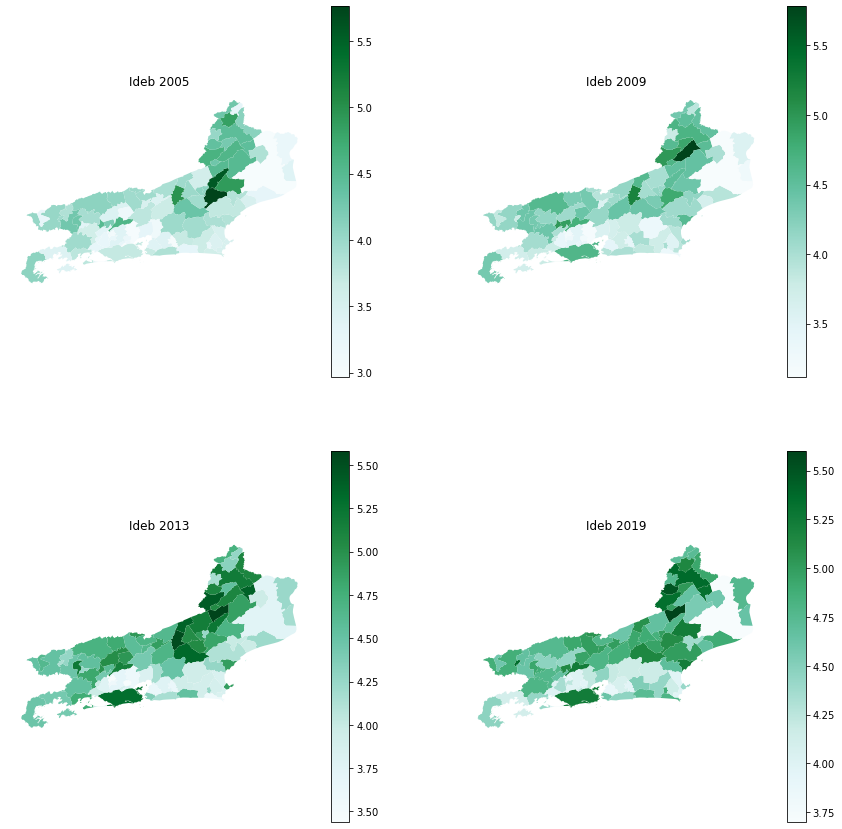

In [52]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(15,15))

ax1 = rank2_2005.plot(column= 'ideb', cmap = "BuGn", legend=True, ax = axes[0,0])
ax1.set_title('2005')

ax2 = rank2_2009.plot(column= 'ideb', cmap = "BuGn",  legend=True, ax = axes[0,1])
ax2.set_title('2009')

ax3 = rank2_2013.plot(column= 'ideb', cmap = "BuGn",  legend=True, ax = axes[1,0])
ax3.set_title('2013')

ax4 = rank2_2019.plot(column= 'ideb', cmap = "BuGn",  legend=True, ax = axes[1,1])
ax4.set_title('2019')

ax1.set_axis_off()
ax1.set_title('Ideb 2005')

ax2.set_axis_off()
ax2.set_title('Ideb 2009')

ax3.set_axis_off()
ax3.set_title('Ideb 2013')

ax4.set_axis_off()
ax4.set_title('Ideb 2019')

Há uma melhoria no índice ano contra ano. A cidade do Rio de Janeiro sai da casa de 4,0 (nota média), chegando próximo e 5,5 em 2019. É possível observar que as melhores médias estão no interior do estado.

Text(0.5, 1.0, 'Taxa de Aprovação 2019')

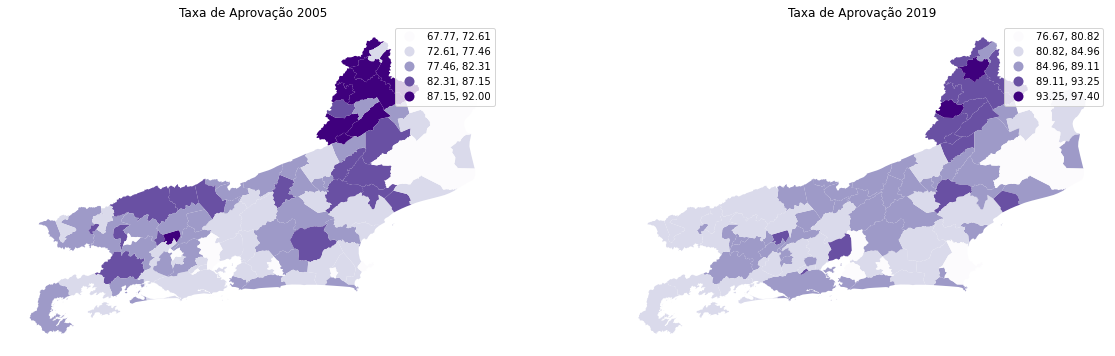

In [53]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,6))

ax1 = rank2_2005.plot(column= 'taxa_aprovacao', cmap = "Purples", scheme="equal_interval", legend=True, ax= axes[0])
ax1.set_title('2005')

ax2 = rank2_2019.plot(column= 'taxa_aprovacao',  cmap = "Purples", scheme="equal_interval", legend=True, ax= axes[1])
ax2.set_title('2019')

ax1.set_axis_off()
ax1.set_title('Taxa de Aprovação 2005')

ax2.set_axis_off()
ax2.set_title('Taxa de Aprovação 2019')

Ao compararmos a taxa de aprovação entre os anos de 2005 e 2019, vemos que houve uma melhoria na taxa entre os 2 anos. 